<h1 style="text-align: center;">MoMo: Final Practice - P2</h1>
<h3 style="text-align: center;">Diego Ontiveros</h3>
<br />
<center>In this notebook the data gathered from the MD simulation is analysed and visualized. This is a general notebook that is used in each simulation to quickly visualize the reults.</center>
<br />
<br />

In [111]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # To avoid scipy optimize warnings

<center>Loading Data.</center>

In [112]:
# Loading data from files
dataT = np.loadtxt("thermodynamics_raw.dat",skiprows=0)         # Thermodynamic data
dataV1 = np.loadtxt("initialV.dat",skiprows=2,usecols=(1,2,3))  # Initial velocities
dataV2 = np.loadtxt("finalV.dat",skiprows=2,usecols=(1,2,3))    # Final velocities
dataR1 = np.loadtxt("initial.xyz",skiprows=2,usecols=(1,2,3))   # Initial positions
dataR2 = np.loadtxt("final.xyz",skiprows=2,usecols=(1,2,3))     # Final positions

data = dataT.T                          # Each parameter in a column

t,Epot,Ekin,E,p,Tinst,P,RMSD = data     # Getting each parameter
t = t*1e12                              # Time in picoseconds (ps)
print(data.shape)


(8, 500000)


In [113]:
# Getting separated position matrices for each frame (to later compute RDF)
with open("trajectory.xyz","r") as inFile:
    pos_data = []
    for i,line in enumerate(inFile):
        line = line.strip().split()

        if i == 0: N = int(line[0])
        if line == []: continue

        data_line = []
        for j,e in enumerate(line):
            try: e = float(e); data_line.append(e)
            except ValueError: pass
            

        pos_data.append(data_line)

positions = []
for i,line in enumerate(pos_data):
    if len(line) == 1: 
        slice = pos_data[i+1:i+N+1]
        positions.append(slice)
positions = np.array(positions)
positions.shape   #(frames,N_particles,dims)


(1001, 256, 3)

<center>Statistichal information of the data.</center>

In [114]:
# Function for Block Averages
def blockAverage(data, maxBlockSize=None):
	"""Computes the block average of a timeseries "x", and 
	provides error bounds for the estimated mean <x>. 

	Parameters
	--------------------
	`data`  : Time series array of an observable X
	`maxBlocksize` : Maximum number of observations/block

	Returns
	--------------------
	`m_points` : Points used (observations/block) for computing averages
	`blockVar` : Variances for each blocksize array 
	`blockMean` : Variances for each blocksize array 	
	"""
 
	Nobs = len(data)           # total number of observations in data
	minBlockSize = 1           # min 1 observation/block
 
	if maxBlockSize is None: maxBlockSize = int(Nobs/4)   # max: 4 blocks (otherwise can't calc variance)
  
	# m_points = 2**n until being less of the inputed maxblocksize
	power = np.arange(int(np.log(maxBlockSize)/np.log(2)))
	m_points = 2**power

	NumBlocks = len(m_points)   				# total number of block sizes

	blockMean = np.zeros(NumBlocks)             # mean for each blocksize
	blockVar  = np.zeros(NumBlocks)             # variance associated with each blockSize


	# Loop for all considered blocksizes (m)
	for k,m in enumerate(m_points):

		Nblock    = int(Nobs/m)               # Number of blocks
		obsProp   = np.zeros(Nblock)          # Container for parcelling block 

		# Loop to chop datastream into blocks and take average
		for i in range(1,Nblock+1):
			
			i1 = (i-1) * m
			i2 =  i1 + m
			obsProp[i-1] = np.mean(data[i1:i2])

		blockMean[k] = np.mean(obsProp)
		blockVar[k]  = np.var(obsProp)/(Nblock - 1)
	
	return m_points, blockVar, blockMean


In [115]:
# Computing Block Averages of diferent data
data_labels = ["Epot (kJ/mol)","Ekin (kJ/mol)","E (kJ/mol)","Pt (g*m/s)","T (K)","P (Pa)","RMSD (A^2)"]
start = 50000                                   # If we want to start from a specific datapoint (discardin 50k first, non equilibrium)

averages,errors = [],[]
for i,xi in enumerate(data[1:]):                # For each data set (avoiding time)
    n_tot = len(xi)
    # Calculate Block Averages (Bining)
    m_points_i,blockVar_i,blockMean_i = blockAverage(xi[start:],maxBlockSize=int(n_tot/100))
    blockSTD_i = np.sqrt(blockVar_i)
    mean = blockMean_i.mean()                                               # Calculation of the total mean (average of BockMeans)
    std = (blockSTD_i[-5:]).mean()                                          # "Real" STD will be the one at large BlockSizes (m) (last values of blockSTD, plateau)
    
    averages.append(mean);errors.append(std)
    # Printing Results
    print(f"Average: <{data_labels[i]}> = {mean:15.5e} +/- {std:.5e}")

# Saving results in output file
with open("BlockAverages.dat","w") as outFile:
    outFile.write("# Block averages and errors for studied themrodynamic properties.\n")
    for i,label in enumerate(data_labels):
        outFile.write(f"{label:>15} {averages[i]}  {errors[i]} \n")



Average: <Epot (kJ/mol)> =    -1.14614e+03 +/- 1.53165e+00
Average: <Ekin (kJ/mol)> =     4.59987e+02 +/- 1.48480e-01
Average: <E (kJ/mol)> =    -6.86149e+02 +/- 1.53408e+00
Average: <Pt (g*m/s)> =     1.76617e+04 +/- 3.34402e+01
Average: <T (K)> =     1.44072e+02 +/- 4.65054e-02
Average: <P (Pa)> =     1.54910e+08 +/- 1.26192e+06
Average: <RMSD (A^2)> =     1.65927e+00 +/- 1.87288e-02


<center>Visualization of the data.</center>

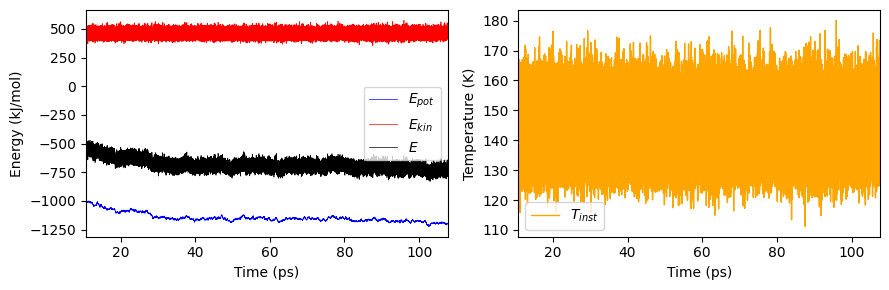

In [116]:
# Plotting data: Energy and temperature
fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

start = 50000     # Starting from a equilibrated point
colors = ["blue","red","black"]
for i,e in enumerate([Epot,Ekin,E]):
    ax1.plot(t[start:],e[start:],c=colors[i], lw=0.5)
    
ax2.plot(t[start:],Tinst[start:],c="orange",lw=1)


ax1.set_xlim(t[start:][0],t[-1]);ax2.set_xlim(t[start:][0],t[-1])
ax1.set_xlabel("Time (ps)");ax1.set_ylabel("Energy (kJ/mol)")
ax2.set_xlabel("Time (ps)");ax2.set_ylabel("Temperature (K)")
ax1.legend(["$E_{pot}$","$E_{kin}$","$E$"]); ax2.legend(["$T_{inst}$"])
fig.tight_layout()
fig.savefig("data1.png", dpi=600) # Saving the resulting plot



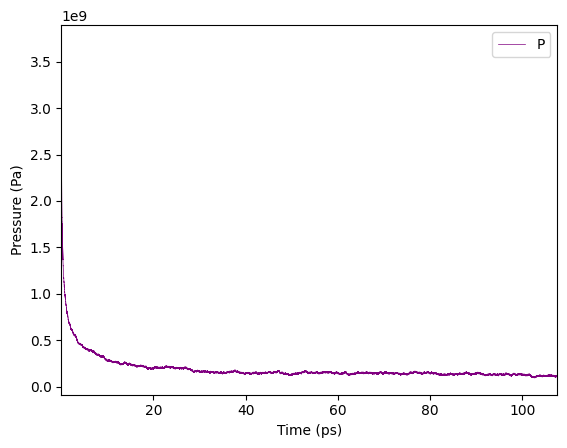

In [117]:
# Ploting Pressure
start = 50
plt.plot(t[start:],P[start:],c="purple", lw=0.5, label="P")
plt.xlim(t[start:][0],t[-1])
plt.xlabel("Time (ps)");plt.ylabel("Pressure (Pa)")
plt.legend()

Difussion coefitient (A^2/ps): D =  3.2232604911782816e-11


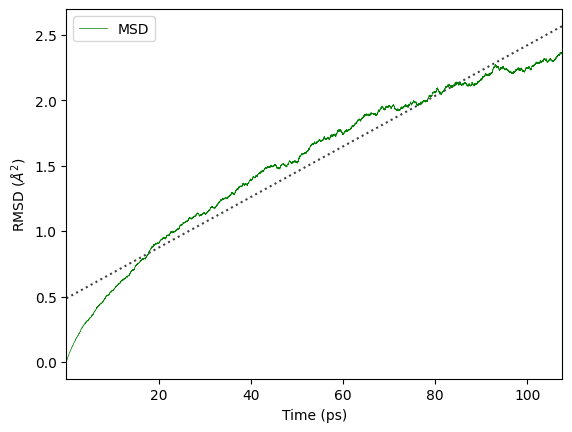

In [118]:
# Ploting MSD and extracting coeff D

start = 0
finish = -1
a,b = np.polyfit(t[start:finish],RMSD[start:finish],deg=1)     # linear fit to ax + b
D = a/6   *1e12 /1e20
print("Difussion coefitient (A^2/ps): D = ",D)

plt.plot(t[start:finish],a*t[start:finish]+b,"k:",alpha=0.75)
plt.plot(t[start:finish],RMSD[start:finish],c="green", lw=0.5, label="MSD")
plt.xlim(t[start:finish][0],t[start:finish][-1])
plt.xlabel("Time (ps)");plt.ylabel("RMSD ($\AA^2$)")
plt.legend()

In [120]:
# Radial Distribution Function
def RDF(movie:np.ndarray,dr,L=None,r_max=None):
    """
    Computes 3D radial distribution function g(r) of a set of particle 
    configurations of shape (N_config,N_particles, dims). 
    
    Parameters
    ----------
    `movie` : (N_config,N_particles, dims) np.array. Set of frame configurations from which to compute the radial distribution function g(r). 
    `dr` : float. Delta r. Determines the spacing between successive radii over which g(r) is computed.
    `L` : float, optional. Length of the simulation box. By default computes one from the positions array.
    `r_max` : float, optional. Maximum radius to compute g(r)
    
    Returns
    -------
    `rdf` : np.array. Radial distribution function values g(r).
    `r` : np.array. radii over which g(r) is computed
    """

    def pbc(dr): 
        for i,dri in enumerate(dr):
            dr[i] = dri - L*round(dri/L)
        return dr

    # Number of configurations and particles
    N_config,N_particles,N_dims = movie.shape  

    # Assigning default values if not present
    if L is None: L = (np.max(movie) - np.min(movie))
    if r_max is None: r_max = 0.5*L

    n_bins = int(r_max/dr)      # Numbers of rdf points (bins os histogram)
    print("L = ",L)
   
    rho = N_particles/L**3            # Number density
    rdf = np.zeros(n_bins)
    for snapshot in movie:

        for i in range(N):
            for j in range(i+1,N):
                drij = snapshot[i] - snapshot[j]        # Distance vector between particles
                drij = pbc(drij)                        # Apply MIC
                d = np.linalg.norm(drij)
                if d < r_max:
                    rdf[int(d/dr)] += 1/L**3            # Account in rdf


    bins_range = np.arange(n_bins)
    r_range = bins_range*dr
    V = 4*np.pi/3 * rho * ((bins_range+0.5)**3 - (bins_range-0.5)**3) * dr**3
    rdf /= N_config * V * 1e-2
   
    return rdf,r_range

L =  23.25544


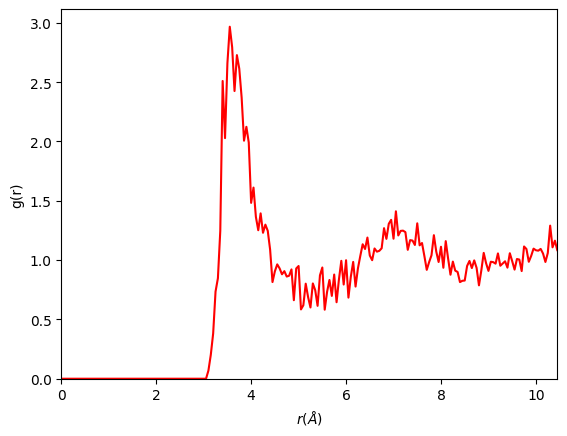

In [121]:
# Plotting RDF for last 100 frames (more becomes expensive)
gdr,r = RDF(positions[0:100],dr=0.05,r_max=10.5)
plt.plot(r,gdr,c="r")
plt.xlabel("$r (\\AA)$");plt.ylabel("g(r)")
plt.xlim(r[0],r[-1])
plt.ylim(ymin=0)
plt.savefig("rdf.png",dpi=600)

120.03848929516478


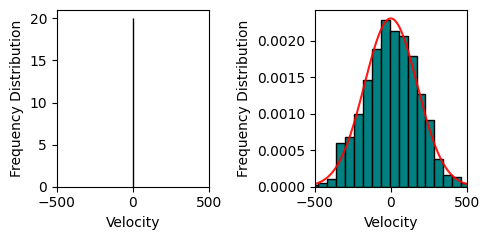

In [122]:
# Velocities distribution
dataV1 = dataV1.flatten()
dataV2 = dataV2.flatten()

fig = plt.figure(figsize=(5,2.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

n_bins = 20
rang = 500

eps = 0.998
R = 8.314
ru_T = 1e3*eps/(R)
print(ru_T)

ax1.hist(dataV1,bins=n_bins,density=True,color="Teal",edgecolor="k")
ax2.hist(dataV2,bins=n_bins,density=True,color="Teal",edgecolor="k")

def mb(T,v): return (1/np.sqrt(2*np.pi*T))*np.exp(-v**2/(2*T))
v = np.linspace(-rang,rang,10000)

mbd = mb(30000,v)
ax2.plot(v,mbd, color="red", alpha=0.9)    


ax1.set_xlim(-rang,rang);ax2.set_xlim(-rang,rang)
ax1.set_xlabel("Velocity");ax1.set_ylabel("Frequency Distribution")
ax2.set_xlabel("Velocity");ax2.set_ylabel("Frequency Distribution")

fig.tight_layout()
# fig.savefig("data2.png", dpi=600) # Saving the resulting plot
